In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys

sys.path.append("../../../")

from utils.plot import (
    config_matplotlib,
    figsize,
    fig_save_and_show,
    plot_events_data,
    plot_efficiency_map_scattered,
)
from utils.optimization import (
    MyOptimizationProblem,
    convert_to_model_params,
    plot_optimization_params,
    plot_optimization_error,
    plot_compare,
    compute_metrics,
    save_model_params_to_json,
    load_model_params_from_json,
)
from utils.data import (
    get_events,
    get_sections,
    load_df,
    process_df,
    export_dataframe_to_latex,
)
from utils.sensitivity_analysis import (
    describe_param_with_uniform_distribution,
    describe_param_with_log_uniform_distribution,
    describe_param_with_triangular_distribution,
    describe_param_with_normal_distribution,
    describe_param_with_truncated_normal_distribution,
    describe_param_with_log_normal_distribution,
    wrapped_model_function,
    create_problem_spec_and_sample,
    plot_sampled_distribuitions,
    evaluate_problem,
    analyze_time_step,
    analyze_problem,
    sobol_sensitivity_analysis_from_model_params_to_outputs,
    plot_sensitivity_analysis,
    plot_sensitivity_analysis_heatmaps,
    get_region_mean,
    plot_sensitivity_analysis_bars,
)
from utils.control import (
    step_response,
    plot_step_response_dataframe,
    get_steady_state_map,
)

import warnings

warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = "/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/"
latex_tex_path = "/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/"

# Sensitivity Analysis

In [3]:
from model import DynamicMotor as Motor

Motor.build({})

<NonlinearIOSystem motor: ['motor_v', 'motor_q_load'] -> ['motor_i', 'motor_w']>

In [4]:
steady_state_params = load_model_params_from_json('me0909_steady_state_params.json')

motor_params = steady_state_params | {
    'motor_L_A': 50e-06,
    'motor_I_r': 1e-2,
    'motor_I_r_load': 0,
}

In [5]:
def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Motor.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method="Radau",
    ).to_pandas()


def motor_sensitivity_analysis_step_response(
    params_description: dict,
    voltage_step: float,
    motor_load_torque_step: float,
    samples: int,
    do_plot=True,
):

    model_class = Motor
    model_params = motor_params
    model_tmp = model_class.build(model_params)

    # Time array
    T = np.linspace(0, 0.1, 11, endpoint=True)

    # Input data
    U = (
        np.empty([model_tmp.ninputs, len(T)]) * np.nan
    )  # nan to force us to define every input
    U[model_tmp.input_labels.index("motor_v")] = voltage_step
    U[model_tmp.input_labels.index("motor_q_load")] = motor_load_torque_step

    # Initial state
    X0 = Motor.initial_state(X0={}, U0=U[:, 0], params=motor_params)

    df_sa, problem = sobol_sensitivity_analysis_from_model_params_to_outputs(
        params_description=params_description,
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model_class,
        model_params=model_params,
        samples=samples,
        calc_second_order=False,
        seed=42,
        nprocs=32,
    )

    df_steady_state_mean = get_region_mean(df_sa, t_start=0.09, t_end=0.1)

    export_dataframe_to_latex(
        filename=f"{latex_tex_path}/motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}.tex",
        label=f"table:motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}",
        caption="Índices de Sobol em regime permanente",
        df_steady_state_mean=df_steady_state_mean,
    )

    if do_plot:
        display(df_steady_state_mean)

        fig_save_and_show(
            filename=f"{latex_img_path}/motor_sensitivity_analysis_distributions.pdf",
            save_title="Distribuição dos valores para cada fator",
            show_title="Distribution of the values for each factor",
            fig=plot_sampled_distribuitions(problem),
            ncols=3,
        )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/motor_sensitivity_analysis_{voltage_step}_{motor_load_torque_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} durante o tempo, com degrau de {voltage_step} [V] e {motor_load_torque_step} [Nm], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} over time with step of {voltage_step} [V] and {motor_load_torque_step} [Nm], with {samples} samples",
                fig=plot_sensitivity_analysis(df_sa, output=output),
                ncols=3,
            )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/motor_sensitivity_analysis_heatmaps_{voltage_step}_{motor_load_torque_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} durante o tempo, com degrau de {voltage_step} [V] e {motor_load_torque_step} [Nm], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} over time with step of {voltage_step} [V] and {motor_load_torque_step} [Nm], with {samples} samples",
                fig=plot_sensitivity_analysis_heatmaps(df_sa, output=output),
                ncols=3,
            )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/motor_sensitivity_analysis_bars_{voltage_step}_{motor_load_torque_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} em regime permanente, com degrau de {voltage_step} [V] e {motor_load_torque_step} [Nm], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} at steady-state with step of {voltage_step} [V] and {motor_load_torque_step} [Nm], with {samples} samples",
                fig=plot_sensitivity_analysis_bars(df_steady_state_mean, output=output),
                ncols=3,
            )

    return df_sa, problem

In [6]:
# Setting all uncertainties to be x%
u_motor_R_A = 1 / 100
u_motor_B = 1 / 100
u_motor_K_Q = 1 / 100
u_motor_K_V = 1 / 100
u_motor_L_A = 1 / 100
u_motor_I_r = 1 / 100
u_motor_I_r_load = 1 / 100

pool
chain


value          conf
output  factor    metric                            
motor_i motor_R_A S1      1.384679e-05  1.504425e-04
                  ST      1.889677e-04  2.932773e-06
        motor_L_A S1      5.386425e-08  4.533141e-06
                  ST      1.851729e-07  2.353711e-09
        motor_K_V S1      9.822711e-01  9.151850e-03
                  ST      9.831220e-01  6.412022e-03
        motor_K_Q S1      8.456589e-03  1.011137e-03
                  ST      8.800904e-03  9.993315e-05
        motor_I_r S1     -1.844170e-07  2.073897e-04
                  ST      3.302931e-04  4.097512e-06
        motor_B   S1      8.409236e-03  9.381783e-04
                  ST      8.409655e-03  9.046871e-05
motor_w motor_R_A S1      1.428117e-05  4.025455e-05
                  ST      1.499198e-05  1.896039e-07
        motor_L_A S1     -8.370947e-10  3.158879e-07
                  ST      9.192189e-10  1.155816e-11
        motor_K_V S1      9.999551e-01  9.139126e-03
                  ST      9.999570e-01  6.346900e-03
        motor_K_Q S1      1.435888e-05  4.289917e-05
                  ST      1.500111e-05  1.741083e-07
        motor_I_r S1      7.460670e-09  8.406754e-06
                  ST      5.628679e-07  6.952630e-09
        motor_B   S1      1.426569e-05  3.921319e-05
                  ST      1.426985e-05  1.559198e-07

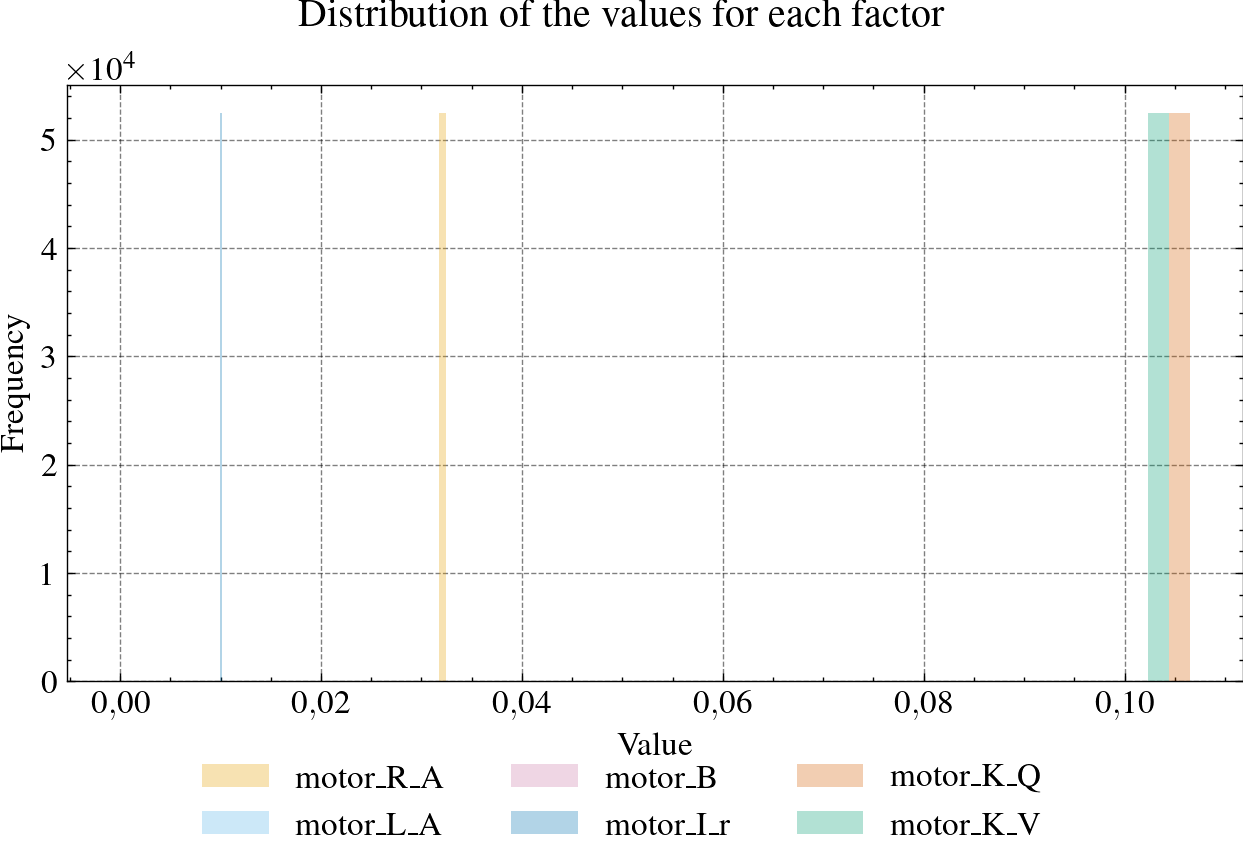

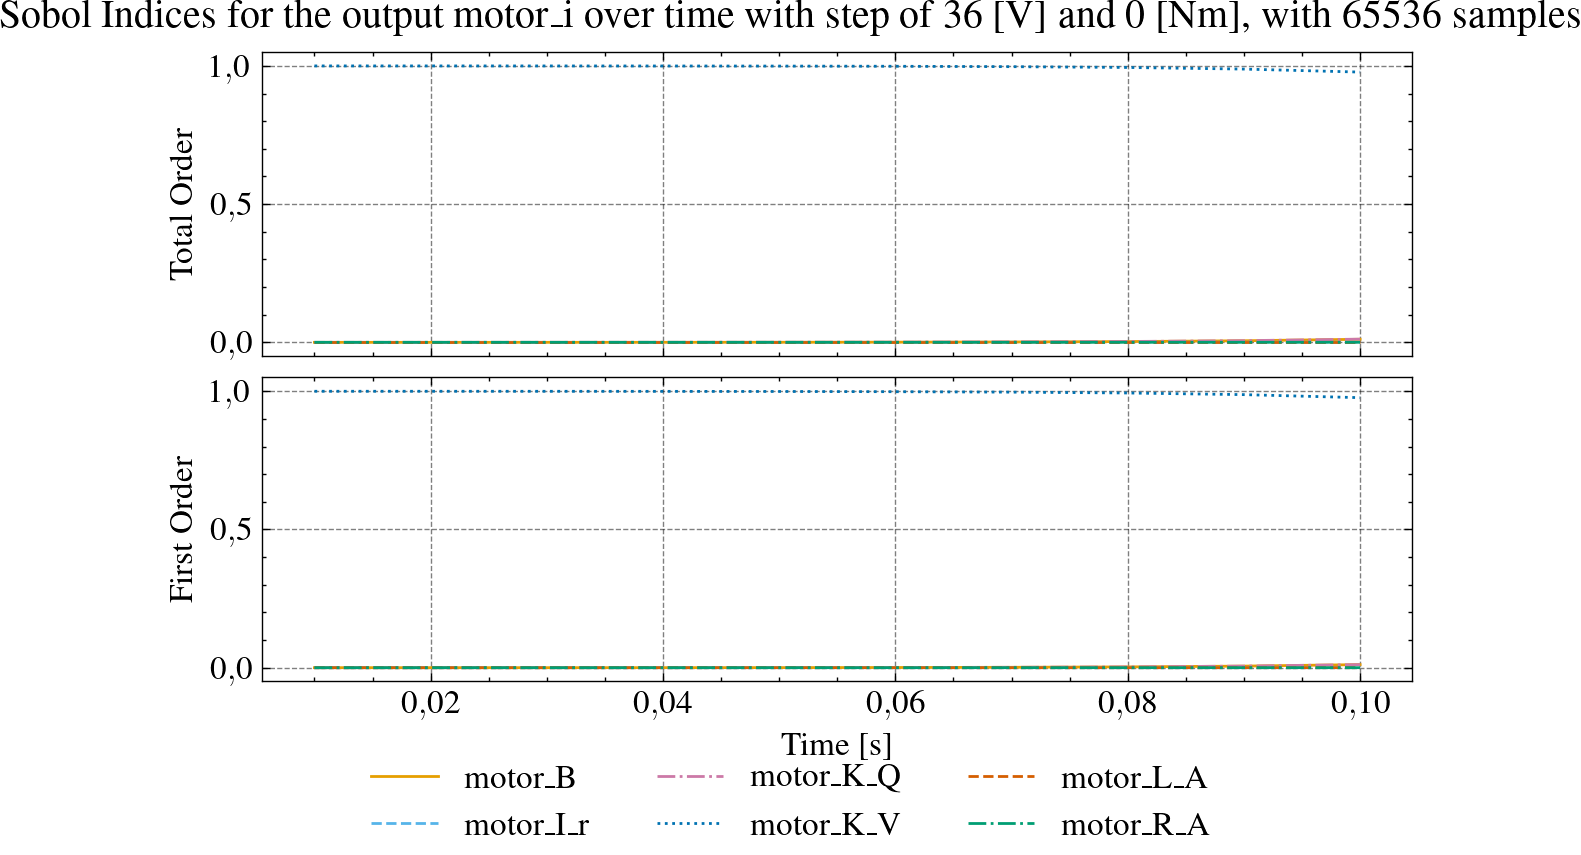

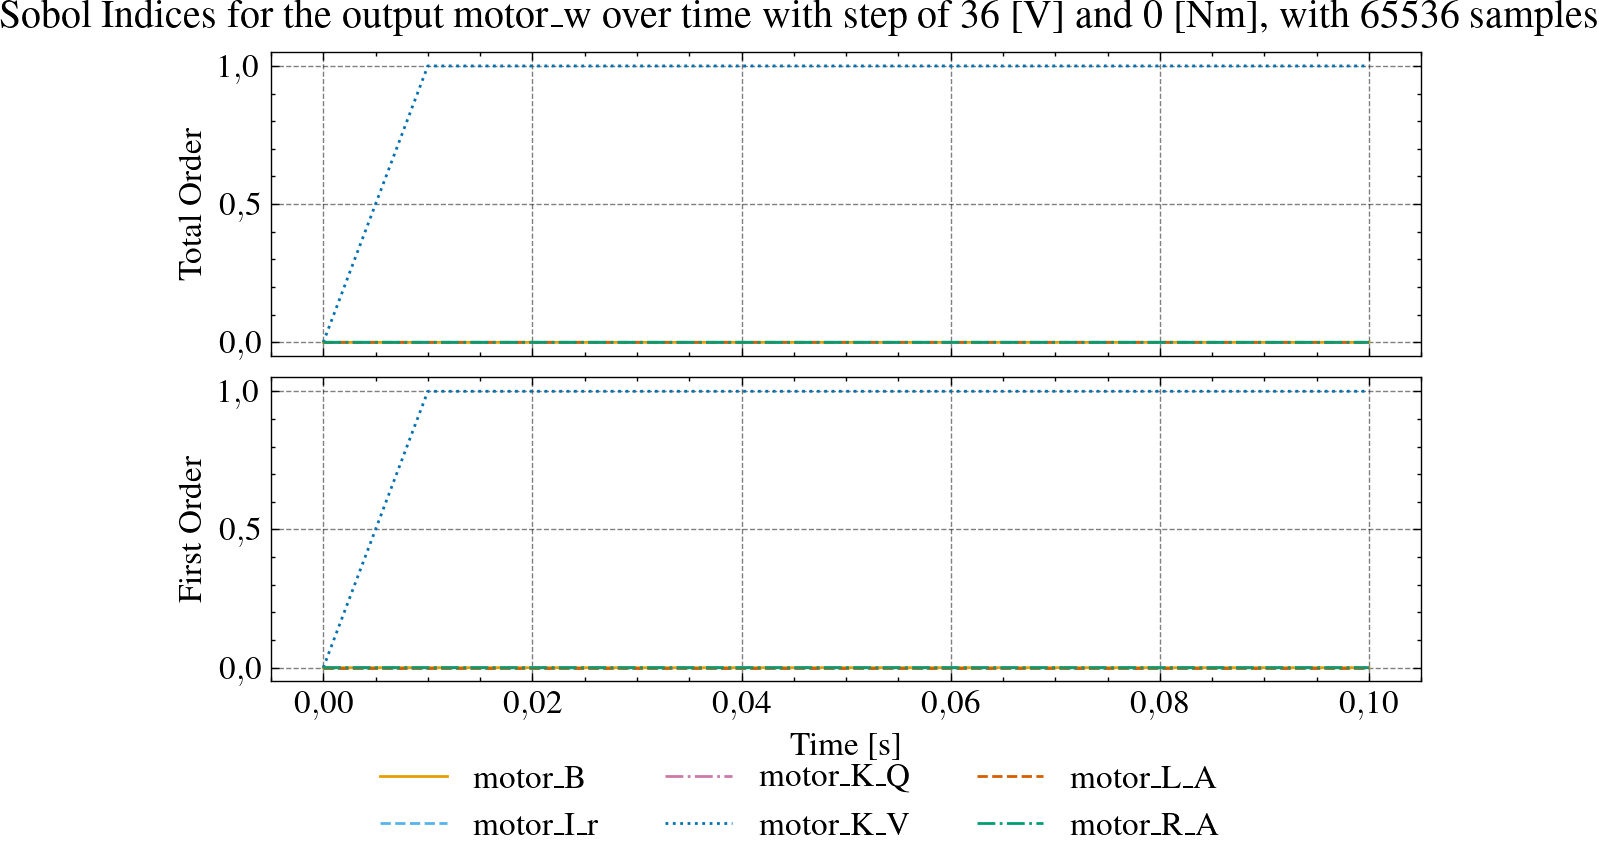

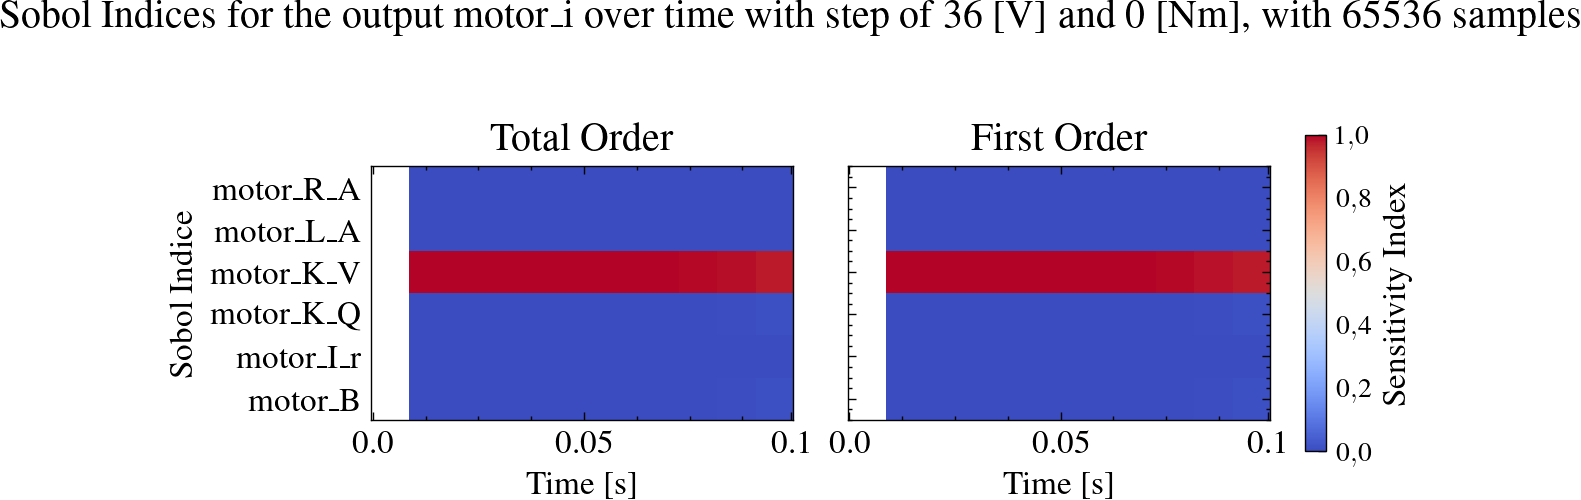

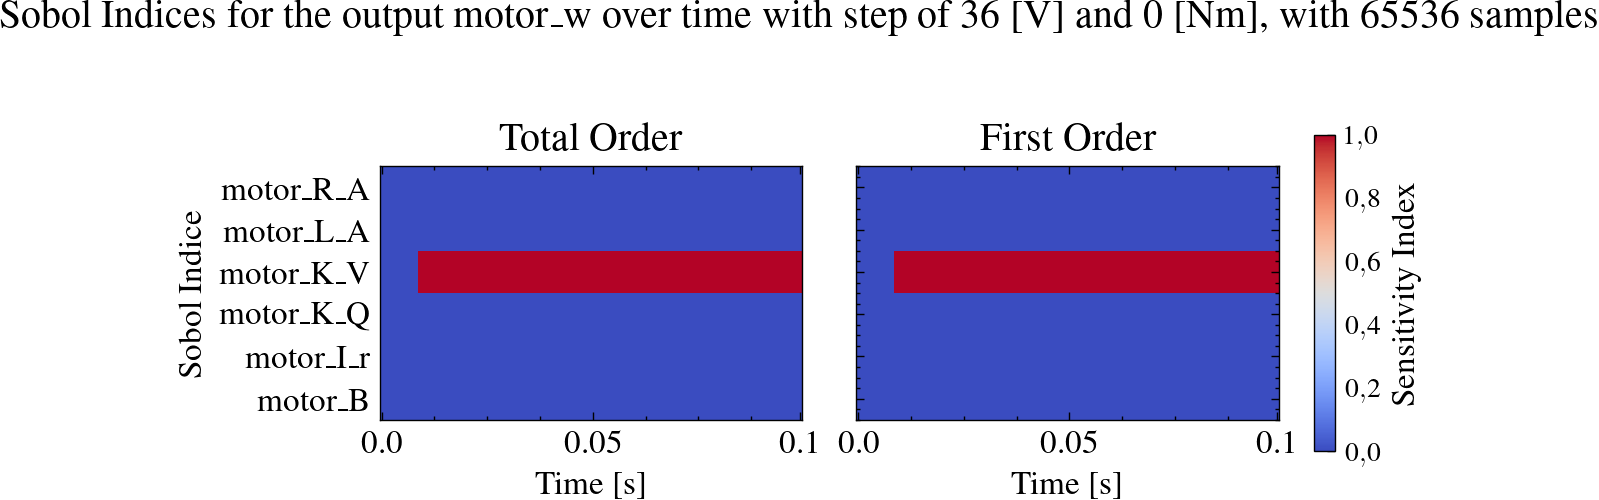

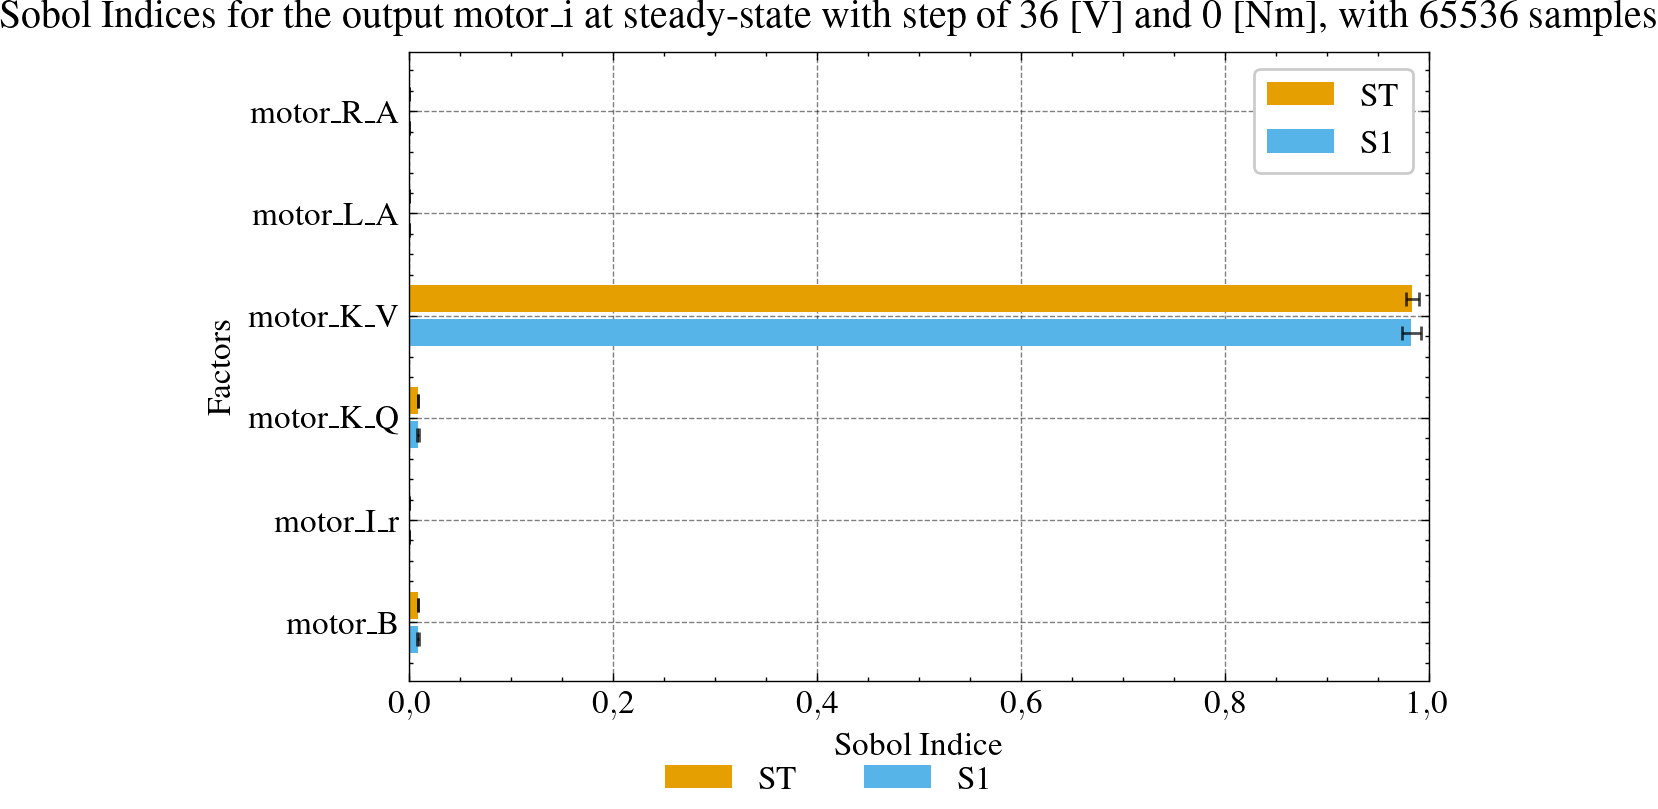

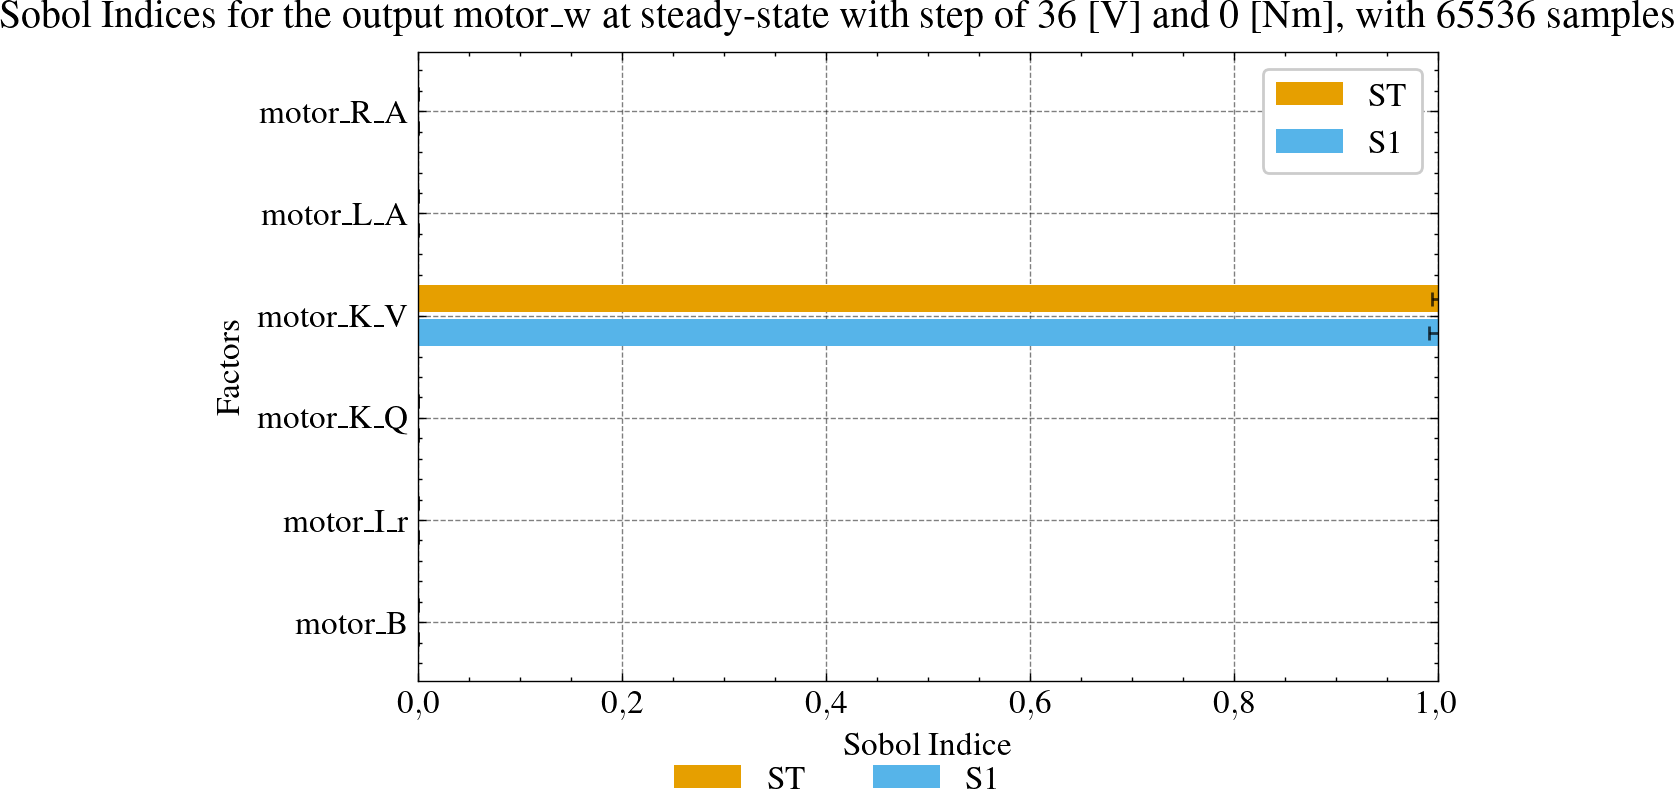

pool
chain


value          conf
output  factor    metric                            
motor_i motor_R_A S1      1.514577e-03  4.435451e-04
                  ST      1.541944e-03  1.939169e-05
        motor_L_A S1     -1.193209e-07  1.883337e-06
                  ST      3.387679e-08  1.327208e-09
        motor_K_V S1      1.634681e-01  3.686728e-03
                  ST      1.635929e-01  1.590607e-03
        motor_K_Q S1      8.336162e-01  8.562076e-03
                  ST      8.336650e-01  7.420381e-03
        motor_I_r S1     -1.061152e-06  8.150021e-05
                  ST      5.462641e-05  7.686839e-07
        motor_B   S1      1.270558e-03  4.095920e-04
                  ST      1.270512e-03  1.327291e-05
motor_w motor_R_A S1      9.153160e-03  9.536979e-04
                  ST      9.154913e-03  1.090756e-04
        motor_L_A S1     -1.365202e-08  3.277184e-07
                  ST      9.644187e-10  1.792102e-11
        motor_K_V S1      9.816390e-01  9.125160e-03
                  ST      9.816424e-01  6.524306e-03
        motor_K_Q S1      9.190370e-03  1.059127e-03
                  ST      9.192083e-03  9.564651e-05
        motor_I_r S1      5.995611e-08  8.271624e-06
                  ST      5.623451e-07  6.994345e-09
        motor_B   S1      1.399492e-05  3.876481e-05
                  ST      1.400811e-05  1.558495e-07

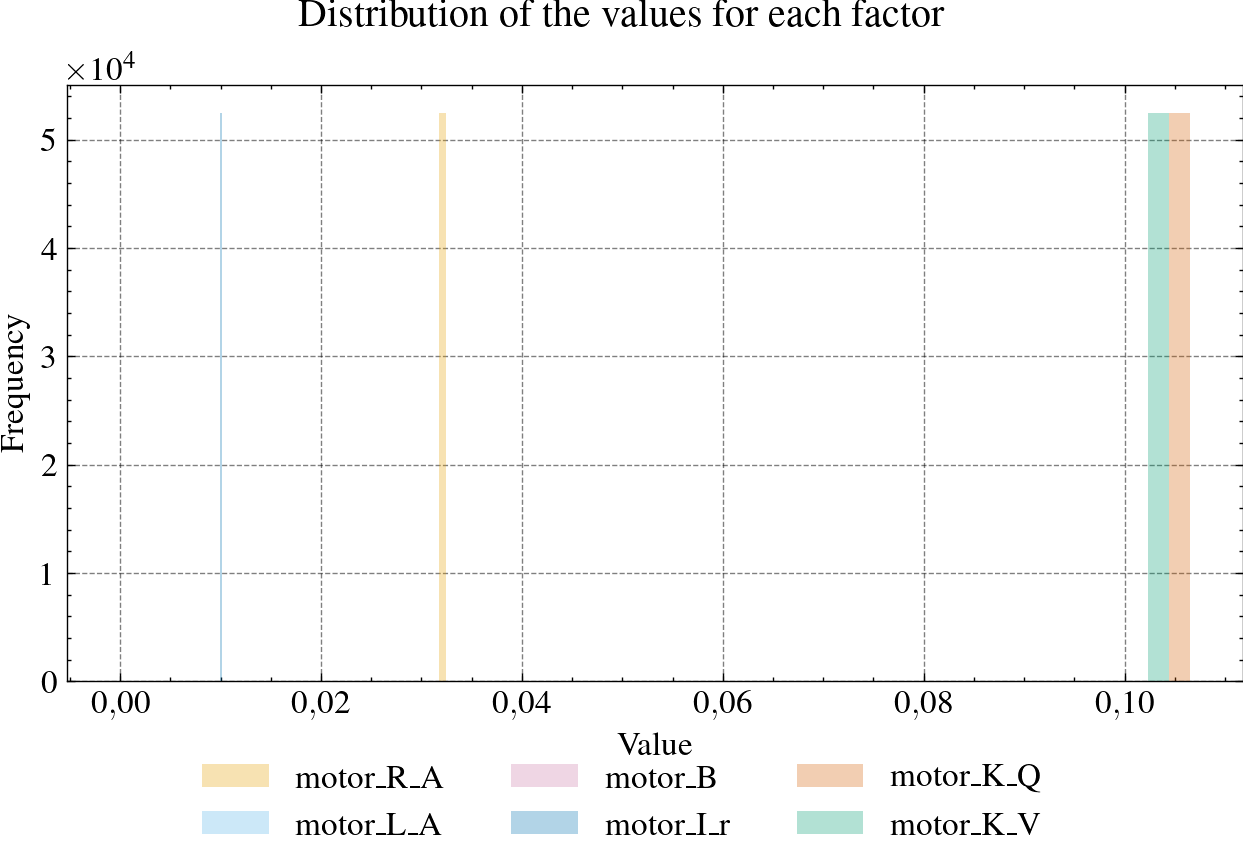

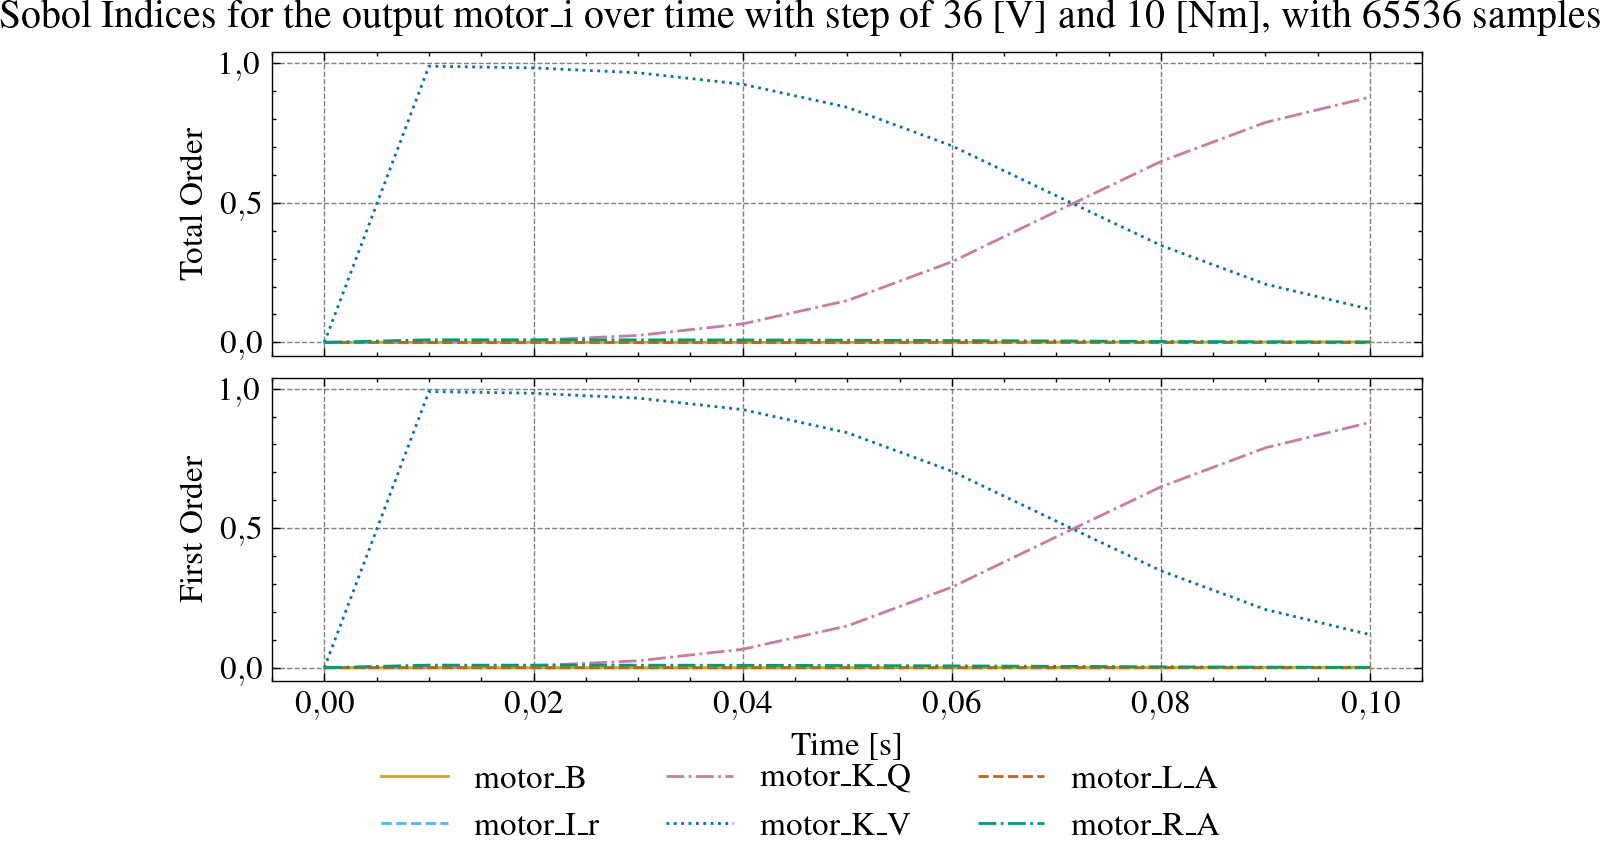

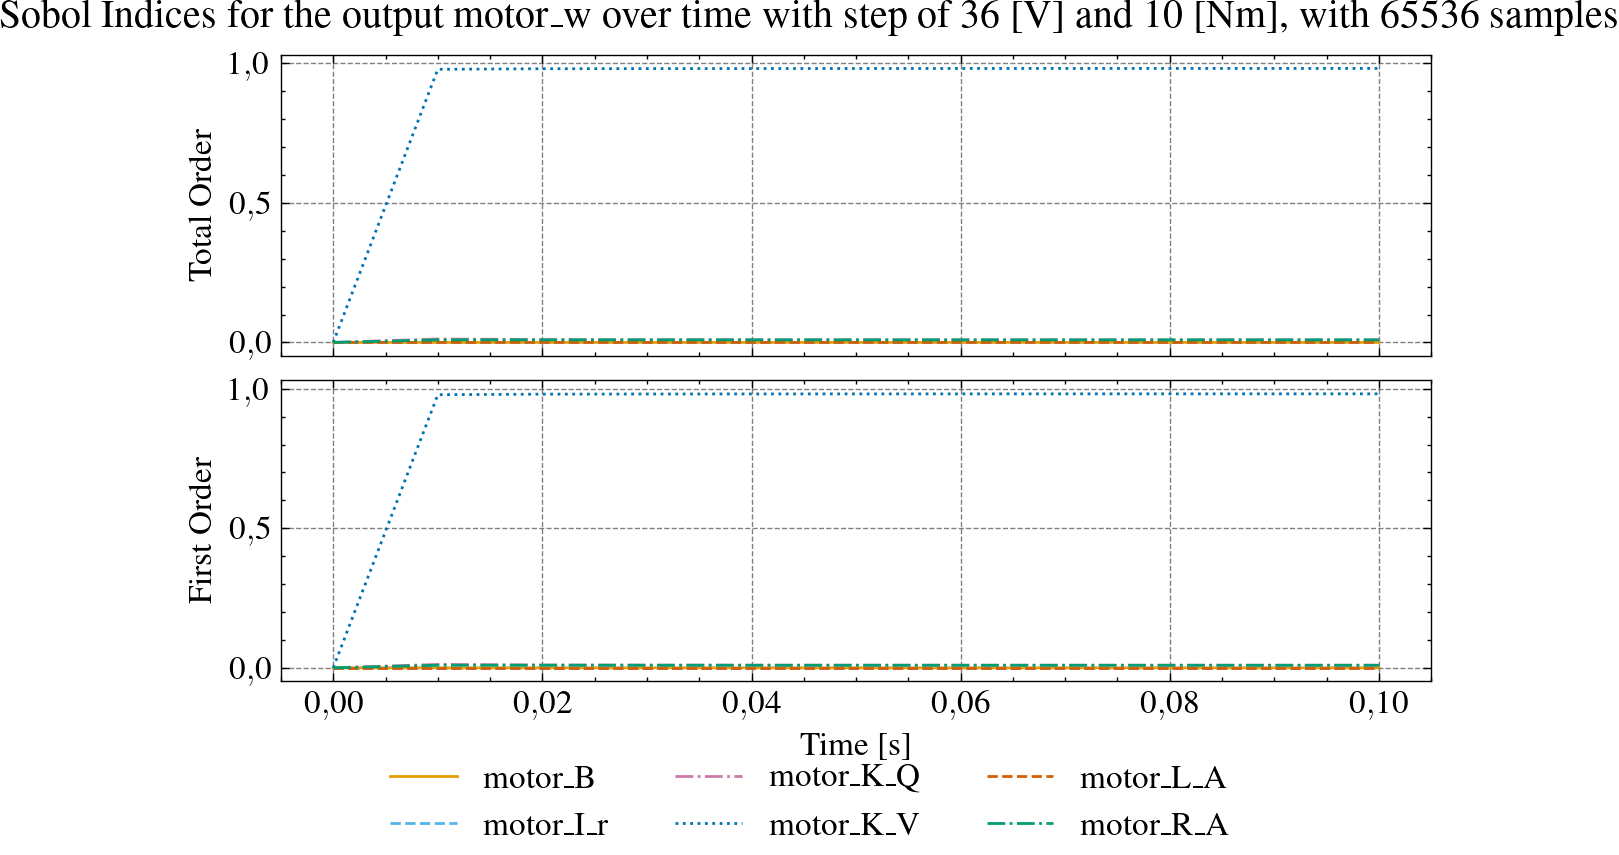

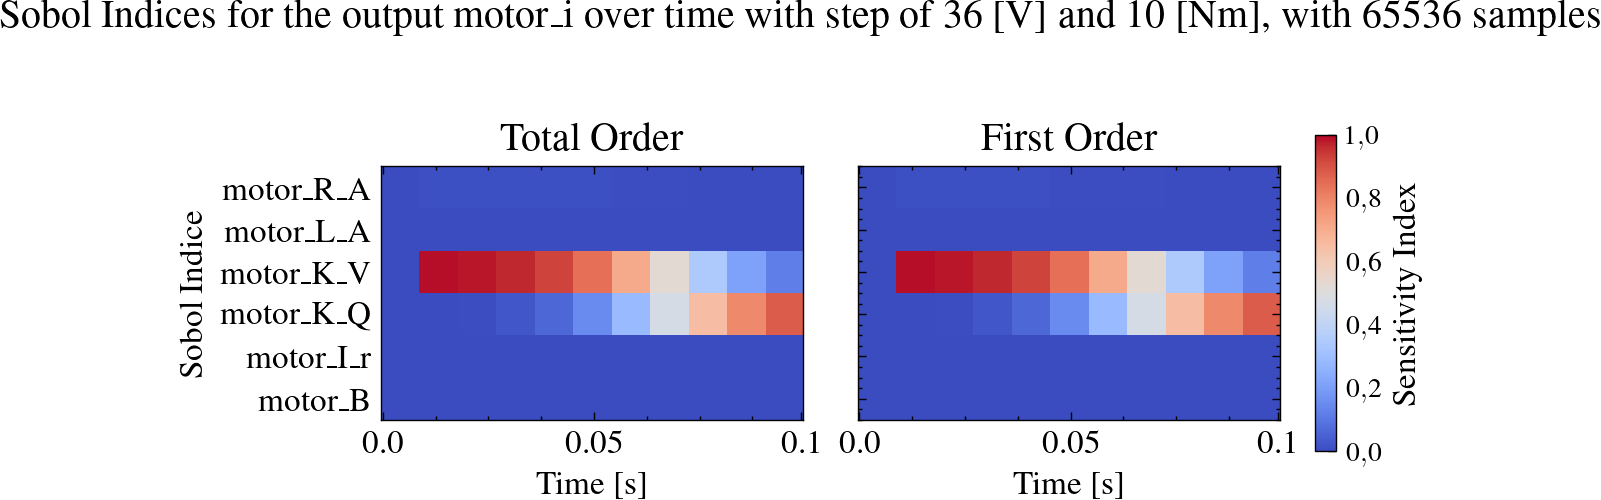

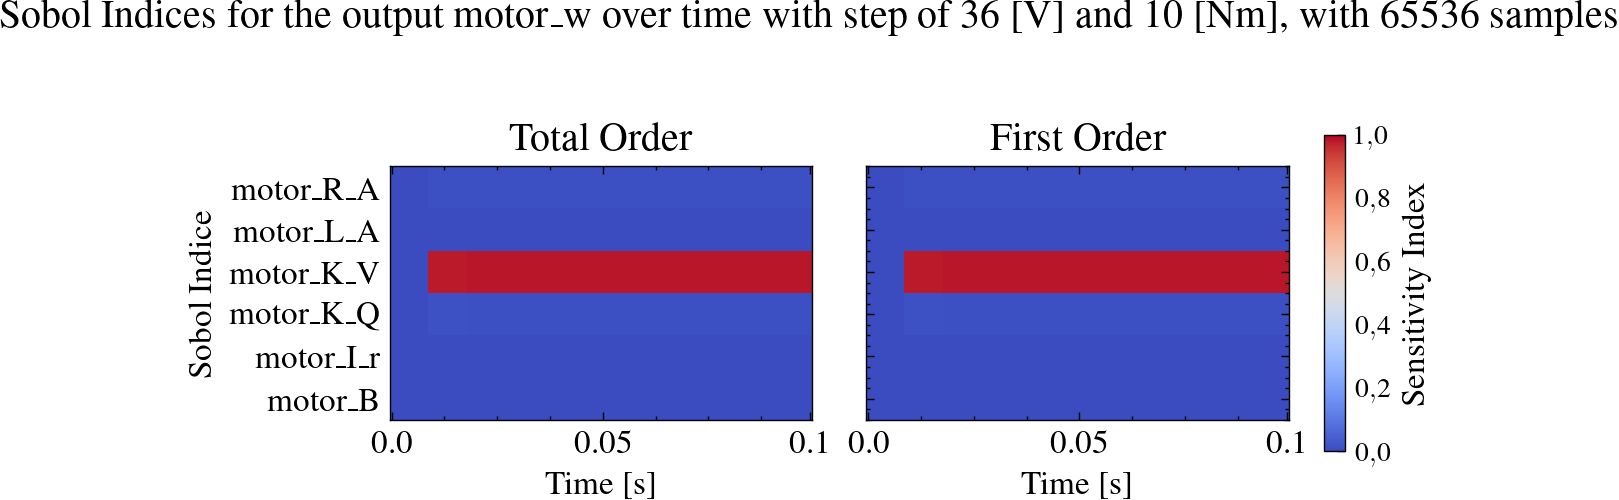

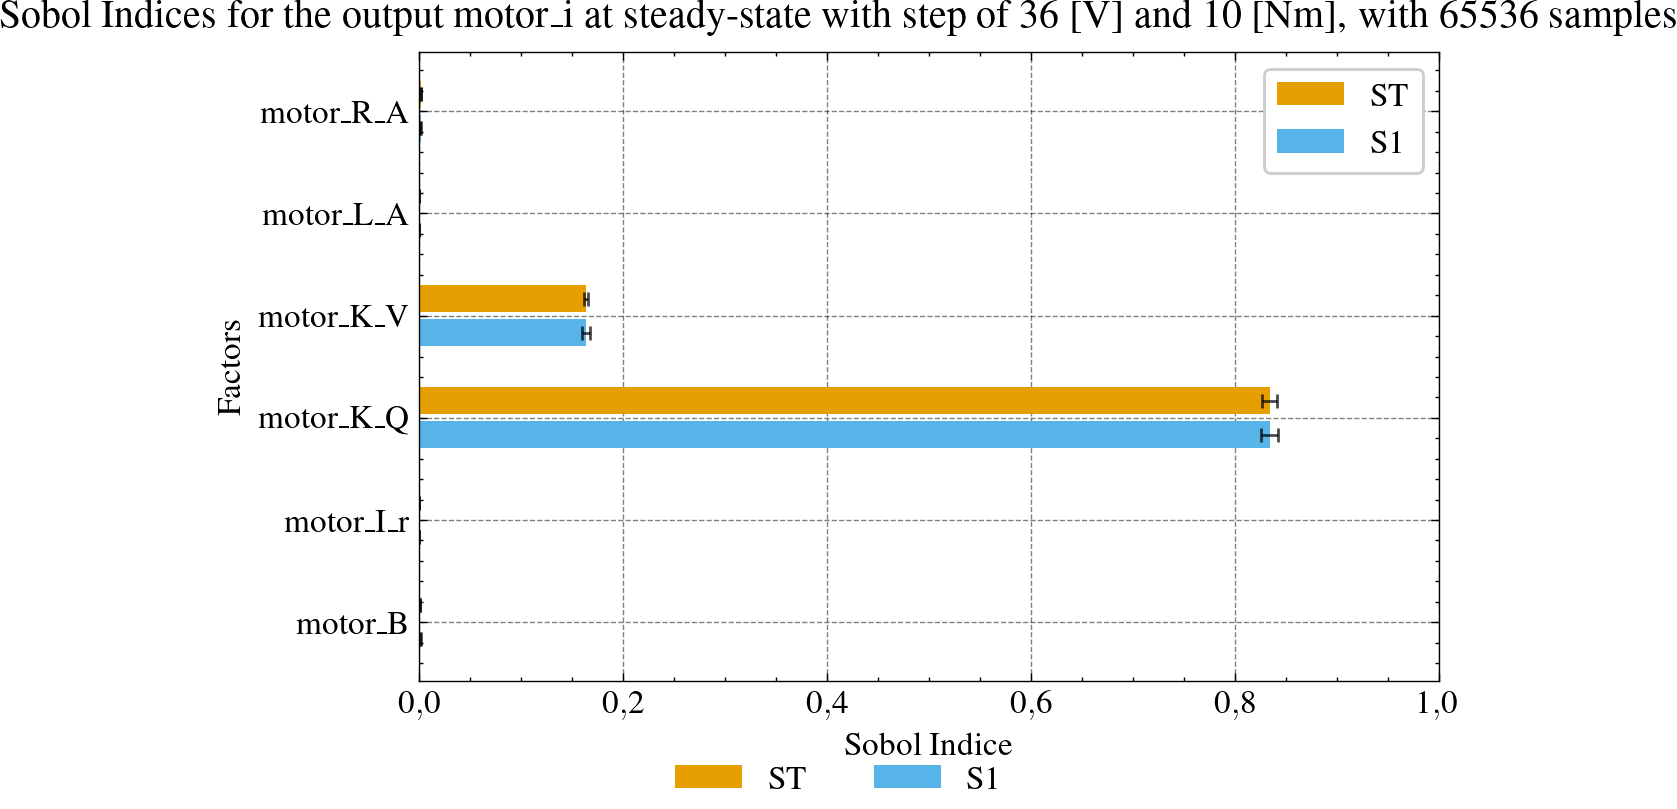

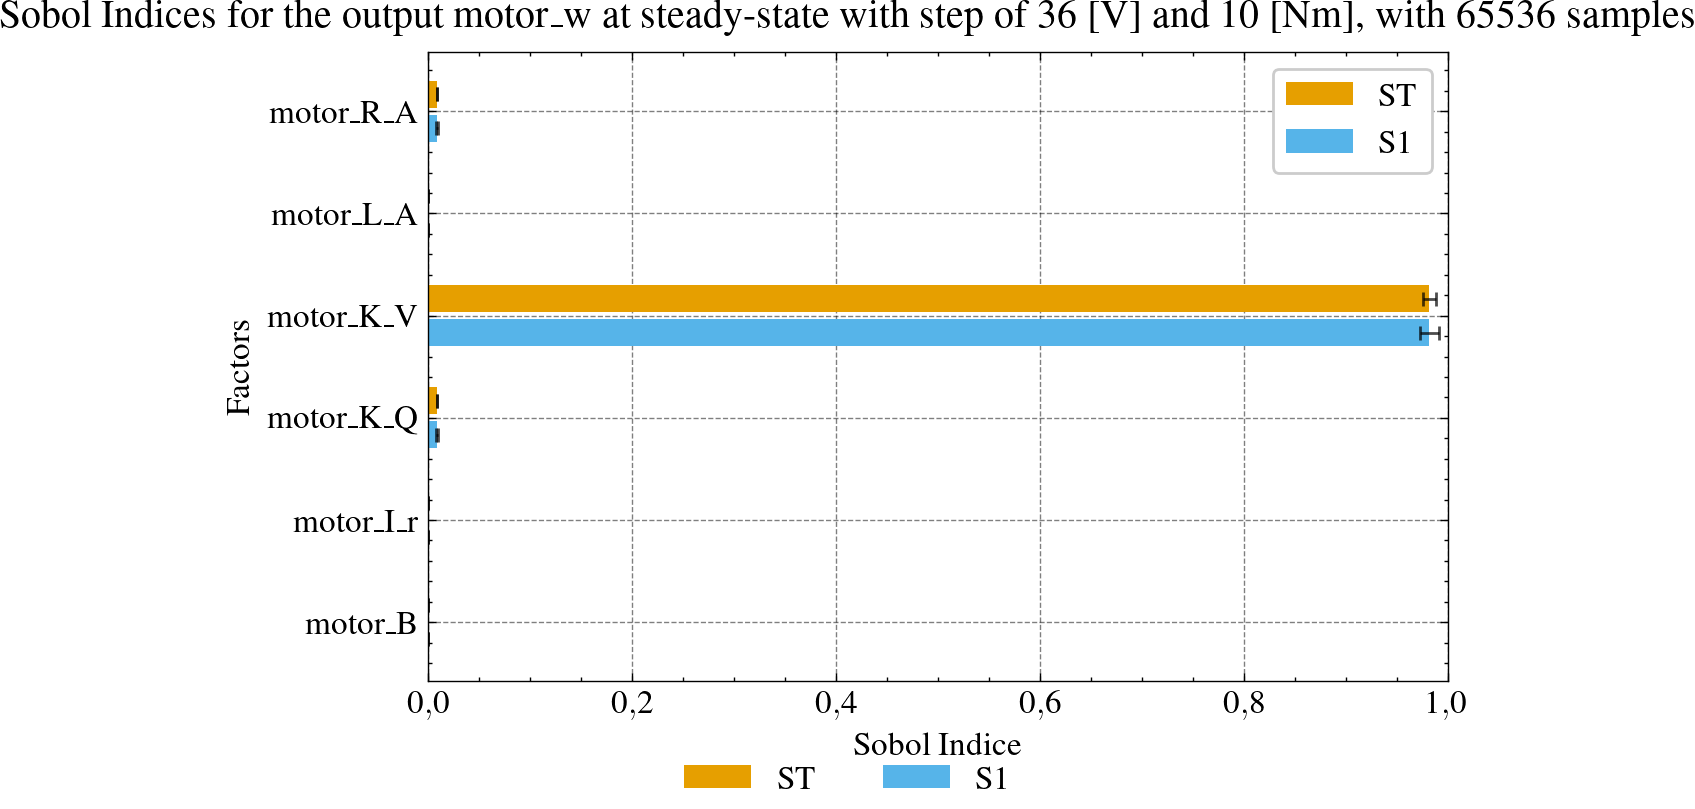

CPU times: user 7.72 s, sys: 9.72 s, total: 17.4 s
Wall time: 2min 11s


In [7]:
%%time

params_description = {
    'motor_R_A': describe_param_with_uniform_distribution(lower=motor_params['motor_R_A']*(1-u_motor_R_A), upper=motor_params['motor_R_A']*(1+u_motor_R_A)),
    'motor_L_A': describe_param_with_uniform_distribution(lower=motor_params['motor_L_A']*(1-u_motor_L_A), upper=motor_params['motor_L_A']*(1+u_motor_L_A)),
    'motor_B': describe_param_with_uniform_distribution(lower=motor_params['motor_B']*(1-u_motor_B), upper=motor_params['motor_B']*(1+u_motor_B)),
    'motor_I_r': describe_param_with_uniform_distribution(lower=motor_params['motor_I_r']*(1-u_motor_I_r), upper=motor_params['motor_I_r']*(1+u_motor_I_r)),
    # 'motor_I_r_load': describe_param_with_uniform_distribution(lower=motor_params['motor_I_r_load']*(1-u_motor_I_r_load), upper=motor_params['motor_I_r_load']*(1+u_motor_I_r_load)),
    'motor_K_Q': describe_param_with_uniform_distribution(lower=motor_params['motor_K_Q']*(1-u_motor_K_Q), upper=motor_params['motor_K_Q']*(1+u_motor_K_Q)),
    'motor_K_V': describe_param_with_uniform_distribution(lower=motor_params['motor_K_V']*(1-u_motor_K_Q), upper=motor_params['motor_K_V']*(1+u_motor_K_Q)),
}

df_sa, problem = motor_sensitivity_analysis_step_response(
    params_description=params_description,
    voltage_step=36,
    motor_load_torque_step=0,
    samples=2**16,
    do_plot=True,
)

df_sa, problem = motor_sensitivity_analysis_step_response(
    params_description=params_description,
    voltage_step=36,
    motor_load_torque_step=10,
    samples=2**16,
    do_plot=True,
)